# Analysis 3: State-Level Analysis and Regularization Effects

This notebook analyzes the relationship between different regularization methods, their parameters, and their effects on:
1. Number of unique neuron states
2. Model performance (train/val accuracy)
3. State distribution characteristics

Expected directory structure:
- runs/fashion_cv_l1_dropoutLows_l2/
  - {method}_{param}/
    - fold_{i}/
      - activations.csv
      - metrics.csv

We'll analyze how different regularization methods affect the network's state space and performance.

In [1]:
# Required imports and setup
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('.')
from src.analysis.analysis import count_unique_states_rounding
# from src.visualization.visualization import setup_plotting_style

# Set plotting style
# setup_plotting_style()

# Constants
ROOT = Path('runs') / 'fashion_cv_l1_dropoutLows_l2'
METHODS = ['l1']  # We only have l1 experiments in this directory
DECIMALS = 2  # Number of decimal places for rounding

In [2]:
# Helper functions for parsing experiment parameters
def extract_method_and_param(directory_name):
    """Extract regularization method and parameter value from directory name."""
    parts = directory_name.split('_')
    
    if 'dropout' in directory_name:
        method = 'dropout'
        param_value = float(parts[-1])
    else:  # l1 or l2
        method = parts[0]
        param_str = parts[-1]
        # Handle scientific notation (e.g., 1e-4)
        if 'e' in param_str:
            base, exp = param_str.split('e')
            param_value = float(base) * (10 ** float(exp))
        else:
            param_value = float(param_str)
            
    return method, param_value

def process_metrics_file(metrics_file):
    """Extract final epoch metrics from metrics.csv."""
    metrics_df = pd.read_csv(metrics_file)
    last_epoch = metrics_df.iloc[-1]
    return last_epoch['train_acc'], last_epoch['val_acc']

def process_activations_file(activations_file, decimals=2):
    """Count unique activation patterns (states) across all images.
    
    Args:
        activations_file: CSV file where:
            - each row is an image
            - each column is a neuron activation
            - so each row is a 64-dim activation pattern
        decimals: Number of decimal places for rounding
        
    Returns:
        Number of unique activation patterns across all images
    """
    activations_df = pd.read_csv(activations_file)
    data = activations_df.values
    
    # Round values to specified decimals
    rounded = np.round(data, decimals=decimals)
    
    # Convert rows to tuples for hashing (to count unique patterns)
    patterns = [tuple(row) for row in rounded]
    
    # Return number of unique activation patterns
    return len(set(patterns))

In [3]:
# Collect experiment directories and results
experiments = []

# Find all experiment directories
for exp_dir in ROOT.glob('*'):
    if not exp_dir.is_dir() or exp_dir.name == 'baseline':
        continue
    
    # Debug: Print directory name
    print(f"\nProcessing directory: {exp_dir.name}")
    
    # Extract method and parameter value
    try:
        method, param_value = extract_method_and_param(exp_dir.name)
        print(f"Extracted method: {method}, param: {param_value}")
    except Exception as e:
        print(f"Error processing directory {exp_dir.name}: {str(e)}")
        continue
    
    # Find all fold directories - note: they're named 'fold1', 'fold2', etc.
    fold_dirs = list(exp_dir.glob('fold*'))
    print(f"Found {len(fold_dirs)} fold directories")
    
    for fold_dir in fold_dirs:
        fold_num = int(fold_dir.name.replace('fold', ''))  # Extract number from fold1, fold2, etc.
        metrics_file = fold_dir / 'metrics.csv'
        
        # Find all activation files (they're named 'activations_collected_epoch20_foldX.csv')
        activation_files = list(fold_dir.glob('activations_collected_epoch20_fold*.csv'))
        print(f"\nFold {fold_num}: Found {len(activation_files)} activation files:")
        
        val_file = None
        train_files = []
        
        # Separate validation and training files
        for act_file in activation_files:
            file_fold = int(act_file.name.split('_')[-1].replace('.csv', '').replace('fold', ''))
            if file_fold == fold_num:
                val_file = act_file
                print(f"  Validation file: {act_file.name}")
            else:
                train_files.append(act_file)
                print(f"  Training file: {act_file.name}")
                
        if val_file and metrics_file.exists():
            experiments.append({
                'dir': fold_dir,
                'method': method,
                'param_value': param_value,
                'val_activations': val_file,
                'train_activations': train_files,
                'metrics_file': metrics_file,
                'fold': fold_num
            })
        else:
            print(f"  Skipping fold {fold_num} - missing validation file or metrics")

print(f"\nSummary:")
print(f"Found {len(experiments)} experiment runs across {len(set(exp['method'] for exp in experiments))} methods")
method_counts = {}
for exp in experiments:
    method_counts[exp['method']] = method_counts.get(exp['method'], 0) + 1
print("Experiments per method:", method_counts)


Processing directory: l1_weight_1.0
Extracted method: l1, param: 1.0
Found 2 fold directories

Fold 1: Found 2 activation files:
  Validation file: activations_collected_epoch20_fold1.csv
  Training file: activations_collected_epoch20_fold2.csv

Fold 2: Found 2 activation files:
  Training file: activations_collected_epoch20_fold1.csv
  Validation file: activations_collected_epoch20_fold2.csv

Processing directory: l1_weight_1e-1
Extracted method: l1, param: 0.1
Found 2 fold directories

Fold 1: Found 2 activation files:
  Validation file: activations_collected_epoch20_fold1.csv
  Training file: activations_collected_epoch20_fold2.csv

Fold 2: Found 2 activation files:
  Training file: activations_collected_epoch20_fold1.csv
  Validation file: activations_collected_epoch20_fold2.csv

Processing directory: l1_weight_1e-2
Extracted method: l1, param: 0.01
Found 2 fold directories

Fold 1: Found 2 activation files:
  Validation file: activations_collected_epoch20_fold1.csv
  Training fil

In [4]:
# Process experiments and build DataFrame
rows = []

for exp in experiments:
    try:
        # Process metrics
        train_acc, val_acc = process_metrics_file(exp['metrics_file'])
        print(f"\nProcessing {exp['method']} experiment, fold {exp['fold']}:")
        print(f"  Accuracies - Train: {train_acc:.4f}, Val: {val_acc:.4f}")
        
        try:
            # Process validation activations
            val_states = process_activations_file(exp['val_activations'])
            print(f"  Validation states: {val_states}")
            
            # Process training activations (average across files)
            train_states = []
            for train_file in exp['train_activations']:
                states = process_activations_file(train_file)
                train_states.append(states)
                print(f"  Training states from {train_file.name}: {states}")
            
            avg_train_states = np.mean(train_states) if train_states else None
            print(f"  Average training states: {avg_train_states}")
            
            # Add to results
            row = {
                'method': exp['method'],
                'param_value': exp['param_value'],
                'fold': exp['fold'],
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_states': val_states,
                'train_states': avg_train_states
            }
            rows.append(row)
            print("  Row added successfully")
            
        except Exception as e:
            print(f"  Error processing activation files: {str(e)}")
            print(f"  File being processed: {exp['val_activations']}")
            print("  Skipping this experiment")
            continue
            
    except Exception as e:
        print(f"Error processing experiment: {str(e)}")
        continue

# Create DataFrame
df = pd.DataFrame(rows)
print("\nDataFrame info:")
print(df.info())

# Print summary statistics
print("\nSummary statistics:")
if len(df) > 0:
    print("\nValidation States:")
    print(df.groupby('method')[['train_acc', 'val_acc', 'val_states']].describe())
    if not df['train_states'].isna().all():
        print("\nTraining States:")
        print(df.groupby('method')[['train_states']].describe())
else:
    print("No data was processed successfully")


Processing l1 experiment, fold 1:
  Accuracies - Train: 0.2884, Val: 0.2629
  Validation states: 30000
  Validation states: 30000
  Training states from activations_collected_epoch20_fold2.csv: 30000
  Average training states: 30000.0
  Row added successfully

Processing l1 experiment, fold 2:
  Accuracies - Train: 0.3247, Val: 0.4043
  Training states from activations_collected_epoch20_fold2.csv: 30000
  Average training states: 30000.0
  Row added successfully

Processing l1 experiment, fold 2:
  Accuracies - Train: 0.3247, Val: 0.4043
  Validation states: 30000
  Validation states: 30000
  Training states from activations_collected_epoch20_fold1.csv: 30000
  Average training states: 30000.0
  Row added successfully

Processing l1 experiment, fold 1:
  Accuracies - Train: 0.1921, Val: 0.2391
  Training states from activations_collected_epoch20_fold1.csv: 30000
  Average training states: 30000.0
  Row added successfully

Processing l1 experiment, fold 1:
  Accuracies - Train: 0.1921,

C:\Users\Adam\AppData\Local\Temp\ipykernel_21448\1661529604.py:10: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(method_data['val_states'], method_data['val_acc'], 1)


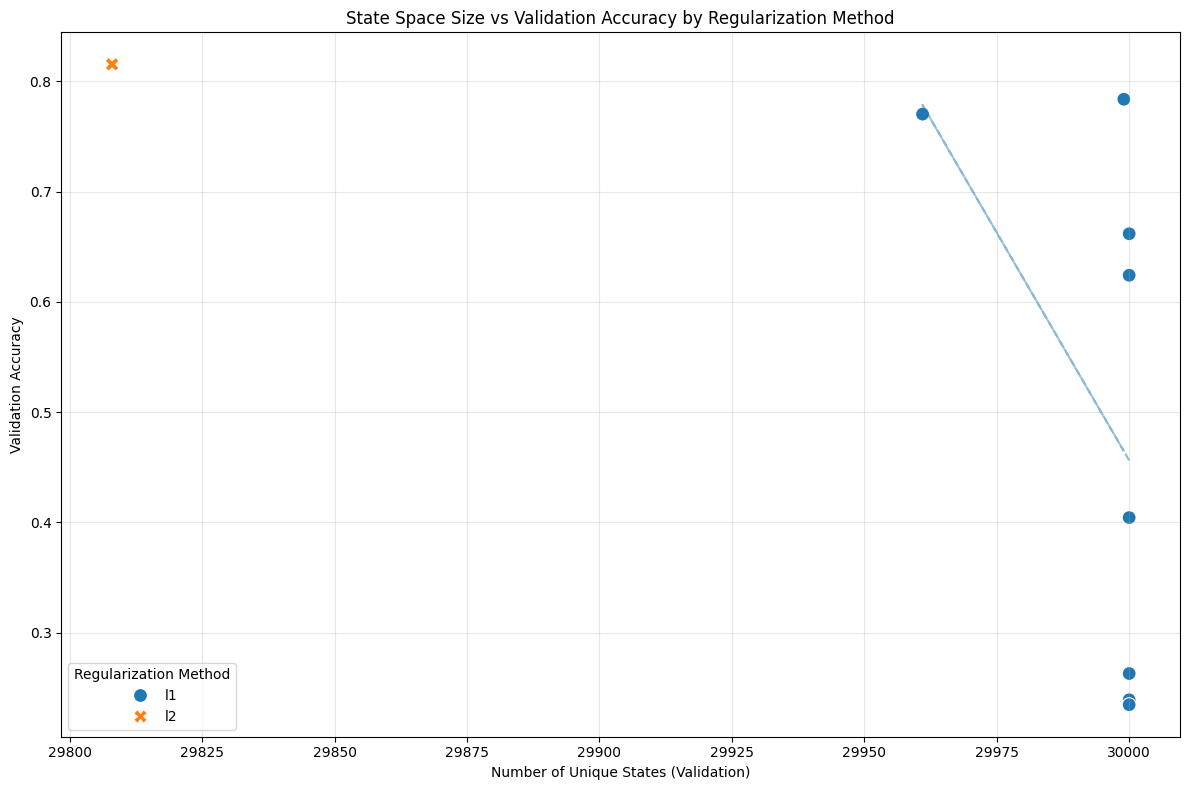

In [5]:
# Plot 1: Combined State Space vs Performance Plot
plt.figure(figsize=(12, 8))

# Create scatter plot
sns.scatterplot(data=df, x='val_states', y='val_acc', hue='method', style='method', s=100)

# Add trend lines
for method in df['method'].unique():
    method_data = df[df['method'] == method]
    z = np.polyfit(method_data['val_states'], method_data['val_acc'], 1)
    p = np.poly1d(z)
    plt.plot(method_data['val_states'], p(method_data['val_states']), 
             linestyle='--', alpha=0.5)

plt.title('State Space Size vs Validation Accuracy by Regularization Method')
plt.xlabel('Number of Unique States (Validation)')
plt.ylabel('Validation Accuracy')
plt.legend(title='Regularization Method')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [6]:
df

,method,param_value,fold,train_acc,val_acc,val_states,train_states
0,l1,1.000,1,0.288367,0.262900,30000,30000.0
1,l1,1.000,2,0.324667,0.404333,30000,30000.0
2,l1,0.100,1,0.192133,0.239067,30000,30000.0
3,l1,0.100,2,0.200533,0.234633,30000,30000.0
4,l1,0.010,1,0.633100,0.624133,30000,30000.0
5,l1,0.010,2,0.675833,0.661767,30000,30000.0
6,l1,0.001,1,0.793567,0.770267,29961,29948.0
7,l1,0.001,2,0.794333,0.783767,29999,29999.0
8,l2,0.001,1,0.834767,0.815400,29808,29814.0


C:\Users\Adam\AppData\Local\Temp\ipykernel_21448\508872950.py:13: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(method_data['val_states'], method_data['val_acc'], 1)
c:\Users\Adam\Desktop\tfg\code\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Adam\Desktop\tfg\code\venv\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Adam\Desktop\tfg\code\venv\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


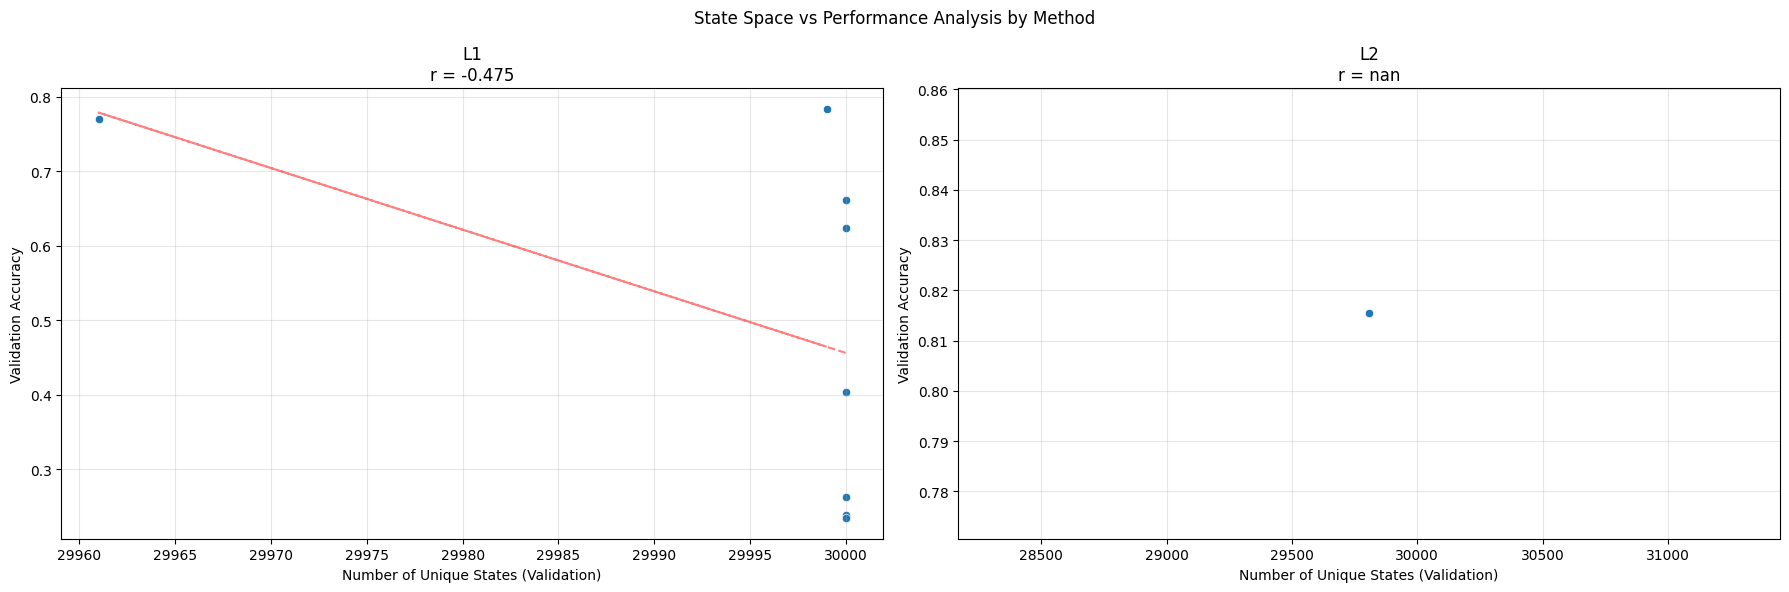

In [7]:
# Plot 2: Per-Method Analysis
methods = sorted(df['method'].unique())
fig, axes = plt.subplots(1, len(methods), figsize=(18, 6))
fig.suptitle('State Space vs Performance Analysis by Method')

for ax, method in zip(axes, methods):
    method_data = df[df['method'] == method]
    
    # Create scatter plot
    sns.scatterplot(data=method_data, x='val_states', y='val_acc', ax=ax)
    
    # Add trend line
    z = np.polyfit(method_data['val_states'], method_data['val_acc'], 1)
    p = np.poly1d(z)
    ax.plot(method_data['val_states'], p(method_data['val_states']), 
            linestyle='--', color='red', alpha=0.5)
    
    # Calculate correlation
    corr = np.corrcoef(method_data['val_states'], method_data['val_acc'])[0,1]
    
    ax.set_title(f'{method.upper()}\nr = {corr:.3f}')
    ax.set_xlabel('Number of Unique States (Validation)')
    ax.set_ylabel('Validation Accuracy')
    ax.grid(True, alpha=0.3)

plt.tight_layout()

C:\Users\Adam\AppData\Local\Temp\ipykernel_21448\1060431291.py:19: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(np.log10(method_data['param_value']), method_data['val_states'], 1)
C:\Users\Adam\AppData\Local\Temp\ipykernel_21448\1060431291.py:27: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(np.log10(method_data['param_value']), method_data['train_states'], 1)


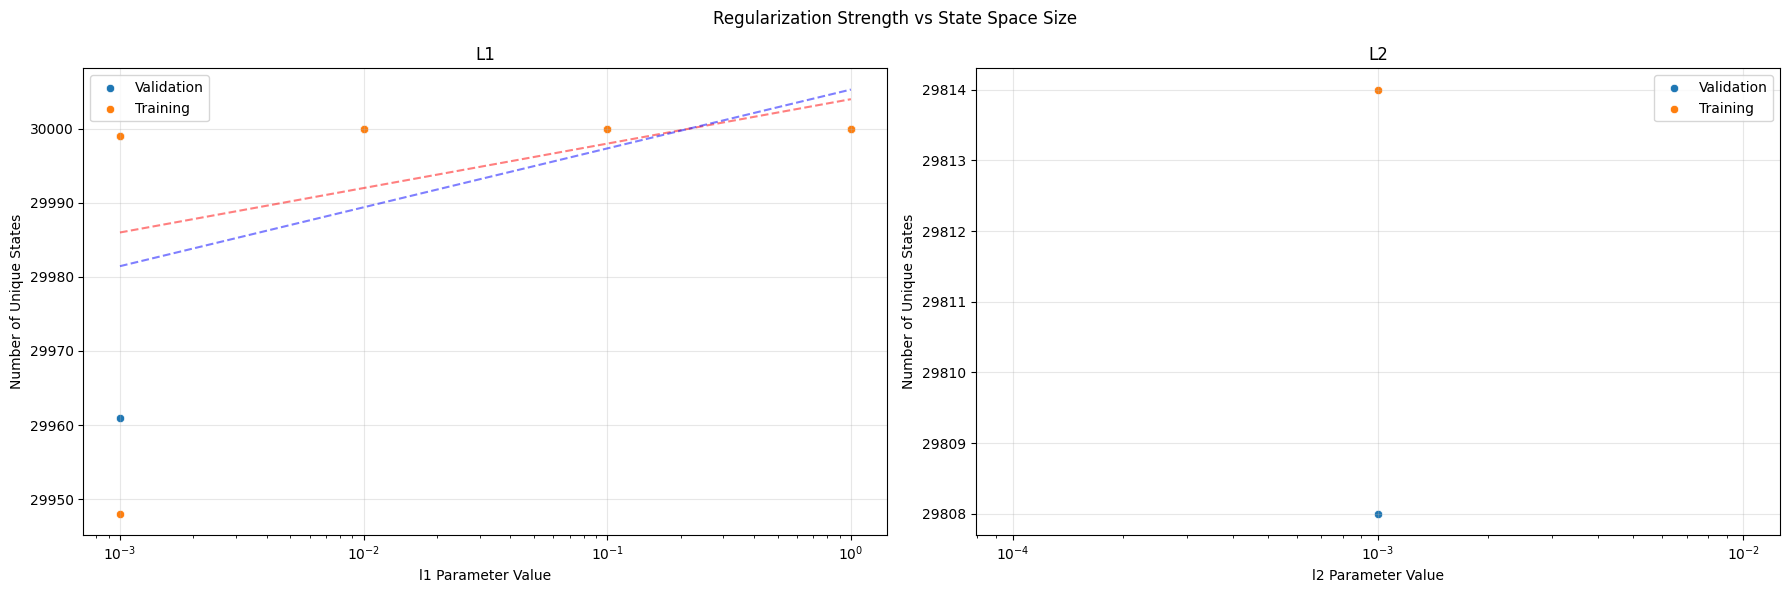

In [8]:
# Plot 3: Parameter Value vs State Space Size
fig, axes = plt.subplots(1, len(methods), figsize=(18, 6))
fig.suptitle('Regularization Strength vs State Space Size')

for ax, method in zip(axes, methods):
    method_data = df[df['method'] == method]
    
    # Create scatter plot for validation states
    sns.scatterplot(data=method_data, x='param_value', y='val_states', label='Validation', ax=ax)
    
    # Add training states if available
    if not method_data['train_states'].isna().all():
        sns.scatterplot(data=method_data, x='param_value', y='train_states', label='Training', ax=ax)
    
    # Use log scale for parameter values
    ax.set_xscale('log')
    
    # Add trend lines
    z = np.polyfit(np.log10(method_data['param_value']), method_data['val_states'], 1)
    p = np.poly1d(z)
    x_range = np.logspace(np.log10(method_data['param_value'].min()), 
                         np.log10(method_data['param_value'].max()), 100)
    ax.plot(x_range, p(np.log10(x_range)), linestyle='--', color='red', alpha=0.5)
    
    # Add trend line for training states if available
    if not method_data['train_states'].isna().all():
        z = np.polyfit(np.log10(method_data['param_value']), method_data['train_states'], 1)
        p = np.poly1d(z)
        ax.plot(x_range, p(np.log10(x_range)), linestyle='--', color='blue', alpha=0.5)
    
    ax.set_title(f'{method.upper()}')
    ax.set_xlabel(f'{method} Parameter Value')
    ax.set_ylabel('Number of Unique States')
    ax.grid(True, alpha=0.3)
    if not method_data['train_states'].isna().all():
        ax.legend()

plt.tight_layout()

In [9]:
# Export results to CSV
# Uncomment to save the results:
# df.to_csv('analysis3_results.csv', index=False)